<a href="https://colab.research.google.com/github/nguyenphan99/CBIR/blob/master/Content-Based_Image_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extract feature

In [1]:
# @title Download dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@title Extract Features from Dataset
!pip install -U opencv-contrib-python==3.3.0.10
!sudo apt-get install redis-server
!pip install redis
import numpy as np
import cv2
from __future__ import print_function
import datetime
import h5py
import sys
from scipy.spatial import distance
from imutils.feature import FeatureDetector_create, DescriptorExtractor_create
from matplotlib import pyplot as plt
import pickle
import imutils
from imutils import paths
import argparse
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise
from scipy.sparse import csr_matrix
from scipy import sparse
from redis import Redis
from collections import namedtuple

class DetectAndDescribe:

    def __init__(self, detector, descriptor):
        # store the keypoint detector and local invariant descriptor
        self.detector = detector
        self.descriptor = descriptor

    def describe(self, image, useKpList = True):
        # detect keypoints in the image and extract local invariant descriptor
        kps = self.detector.detect(image)
        (kps, descs) = self.descriptor.compute(image, kps)

        # if there are no keyponts or descriptors, return None
        if len(kps) == 0:
            return (None, None)

        # check to see if the keypoint should be converted to NumPy array
        if useKpList:
            kps = np.int0([kp.pt for kp in kps])

        # return a tuple of the keypoints and descriptors
        return (kps, descs)

class BaseIndexer(object):

    def __init__(self, dbPath, estNumImages = 500, maxBufferSize = 50000, dbResizeFactor = 2,
        verbose = True):
        # store the database path, estimate number of images in the dataset, max
        # buffer size, the resize factor of the database and the verbosity setting
        self.dbPath = dbPath
        self.estNumImages = estNumImages
        self.maxBufferSize = maxBufferSize
        self.dbResizeFactor = dbResizeFactor
        self.verbose = verbose

        # initialize the indexs dictionary, which will store the current indexes into the respective datasets
        self.idxs = {}

    def _writeBuffers(self):
        pass

    def _writeBuffer(self, dataset, datasetName, buf, idxName, sparse = False):
        # if the buffer is a list, then compute the ending index based on
        # the lists length
        if type(buf) is list:
            end = self.idxs[idxName] + len(buf)

        # otherwise, assume that the buffer is NumPy/SciPy array, so
        # compute the ending index based on the array shape
        else:
            end = self.idxs[idxName] + buf.shape[0]

        # check to see if the dataset need to be resized
        if end > dataset.shape[0]:
            self._debug("triggering '{}' db resize".format(datasetName))
            self._resizeDataset(dataset, datasetName, baseSize = end)

        # if this is a sparse matrix, then convert the sparse matrix to a
        # dense one so it can be written to file
        if sparse:
            buf = buf.toarray()

        # dump the buffer to file
        self._debug("writing '{}' buffer".format(datasetName))
        # self.idx[idxName] an integer pointing to the next open row in the dataset
        dataset[self.idxs[idxName] : end] = buf

    def _resizeDataset(self, dataset, dbName, baseSize = 0, finished = 0):
        # grab the original size of the datset
        origSize = dataset.shape[0]

        # check to see if we are finished writing rows to the dataset, and if
        # so, make the new size the current index
        if finished > 0:
            newSize = finished

        # otherwise, we are enlarging the dataset so calculate the new size
        # of the datset
        else:
            newSize = baseSize * self.dbResizeFactor

        # determine the shape of (to be) the resized dataset
        shape = list(dataset.shape)
        shape[0] = newSize

        # show the old versus new size of the dataset
        dataset.resize(tuple(shape))
        self._debug("old size of '{}': {:,}; new size: {:,}".format(dbName, origSize,
            newSize))

    def _debug(self, msg, msgType = "[INFO]"):
        # check to see the message should be printed
        if self.verbose:
            print("{} {} - {}".format(msgType, msg, datetime.datetime.now()))

    @staticmethod
    def featureStack(array, accum = None, stackMethod = np.vstack):
        # if the accumulated array is None, initialize it
        if accum is None:
            accum = array

        # otherwise, stack the arrays
        else:
            accum = stackMethod([accum, array])

        # return the accumulated array
        return accum
# import packages

class FeatureIndexer(BaseIndexer):

    def __init__(self, dbPath, estNumImages = 500, maxBufferSize = 50000, dbResizeFactor = 2,
        verbose = True):
        # call the parent constructor
        super(FeatureIndexer, self).__init__(dbPath, estNumImages = estNumImages,
            maxBufferSize = maxBufferSize, dbResizeFactor = dbResizeFactor,
            verbose = verbose)

        # open the HDF5 database for writing and initialize the datasets within
        # the group
        self.db = h5py.File(self.dbPath, mode = "w")
        self.imageIDDB = None
        self.indexDB = None
        self.featuresDB = None

        # initialize the image IDs buffer, index buffer, and the keypoints +
        # features buffer
        self.imageIDBuffer = []
        self.indexBuffer = []
        self.featuresBuffer = None

        # initialize the total number of features in the buffer along with the
        # indexs dictionary
        self.totalFeatures = 0
        # index: an integer representing the current row (i.e. the next empty row) in both the image_ids and index datasets.
        # features: An integer representing the next empty row in the features dataset
        self.idxs = {"index": 0, "features": 0}

    def add(self, imageID, kps, features): # add an image and its associated keypoints and features to the HDF5 database
        # compute the starting and ending index for the features lookup
        start = self.idxs["features"] + self.totalFeatures
        end = start + len(features)

        # update the image IDs buffer, features buffer, and index buffer,
        # followed by incrementing the feature count
        self.imageIDBuffer.append(imageID)
        self.featuresBuffer = BaseIndexer.featureStack(np.hstack([kps, features]),
            self.featuresBuffer)
        self.indexBuffer.append((start, end))
        self.totalFeatures += len(features)

        # check to see if we have reached the maximum buffer size
        if self.totalFeatures >= self.maxBufferSize:
            # if the databases have not been created yet, create them
            if None in (self.imageIDDB, self.indexDB, self.featuresDB):
                self._debug("initial buffer full")
                self._createDatasets()

            # write the buffers to file
            self._writeBuffers()

    def _createDatasets(self):
    	# compute the average number of features extracted from the initial buffer
    	# and use this number to determine the approximate number of features for
    	# the entire dataset
    	avgFeatures = self.totalFeatures / float(len(self.imageIDBuffer))
    	approxFeatures = int(avgFeatures * self.estNumImages)

    	# grab the feature vector size
    	fvectorSize = self.featuresBuffer.shape[1]

    	# handle h5py datatype for Python 2.7
    	if sys.version_info[0] < 3:
    		dt = h5py.special_dtype(vlen = unicode)

    	# otherwise use a datatype compatible with Python 3.5
    	else:
    		dt = h5py.special_dtype(vlen = str)

    	# initialize the datasets
    	self._debug("creating datasets...")
    	self.imageIDDB = self.db.create_dataset("image_ids", (self.estNumImages,),
    		maxshape = (None,), dtype = dt)
    	self.indexDB = self.db.create_dataset("index", (self.estNumImages, 2),
    		maxshape = (None, 2), dtype = "int")
    	self.featuresDB = self.db.create_dataset("features",
    		(approxFeatures, fvectorSize), maxshape = (None, fvectorSize),
    		dtype = "float")

    def _writeBuffers(self):
        # write the buffers to disk
        self._writeBuffer(self.imageIDDB, "image_ids", self.imageIDBuffer,
            "index")
        self._writeBuffer(self.indexDB, "index", self.indexBuffer, "index")
        self._writeBuffer(self.featuresDB, "features", self.featuresBuffer,
            "features")

        # increment the indexes
        self.idxs["index"] += len(self.imageIDBuffer)
        self.idxs["features"] += self.totalFeatures

        # reset the buffers and feature counts
        self.imageIDBuffer = []
        self.indexBuffer = []
        self.featuresBuffer = None
        self.totalFeatures = 0

    def finish(self):
        # if the databases have not been initialized, then the original
        # buffers were never filled up ==> large maxBufferSize, small estNumImages
        if None in (self.imageIDDB, self.indexDB, self.featuresDB):
            self._debug("minimum init buffer not reached", msgType = "[WARN]")
            self._createDatasets()

        # write any unempty buffers to file
        self._debug("writing un-empty buffers...")
        self._writeBuffers()

        # compact datasets
        self._debug("compacting datasets...")
        self._resizeDataset(self.imageIDDB, "image_ids", finished = self.idxs["index"])
        self._resizeDataset(self.indexDB, "index", finished = self.idxs["index"])
        self._resizeDataset(self.featuresDB, "features", finished = self.idxs["features"])

        # close the database
        self.db.close()

Requirement already up-to-date: opencv-contrib-python==3.3.0.10 in /usr/local/lib/python3.6/dist-packages (3.3.0.10)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
redis-server is already the newest version (5:4.0.9-1ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
#@title Uncomment and run this code if want to extract and index features
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset",
#                 type = str, 
#                 default='/content/drive/My Drive/oxbuild_images',
#                 help = "Path to the directory that contains the images to be indexed")
# ap.add_argument("-f", "--features_db",
#                 type = str, 
#                 default='/content/drive/My Drive/output/feature.hdf5',
#                 help = "Path to where the features database will be stored")
# ap.add_argument("-a", "--approx_images", 
#                 type = int,
#                 default = 500,
#                 help = "Approximate # of images in the dataset") # allow to estimate size of HDF5 dataset when FeatureIndexer is initialized
# ap.add_argument("-b", "--max_buffer_size", 
#                 type = int, 
#                 default = 50000,
#                 help = "Maximum buffer size for # of features to be stored in memory")
# args = vars(ap.parse_args())

# # initialize the keypoint detector, local invariant descriptor, add descriptor
# # pipeline
# detector = FeatureDetector_create("SURF")
# descriptor = DescriptorExtractor_create("RootSIFT")
# dad = DetectAndDescribe(detector, descriptor)

# # initialize the feature indexer
# fi = FeatureIndexer('/content/drive/My Drive/output/feature.hdf5', estNumImages = args["approx_images"],
#     maxBufferSize = args["max_buffer_size"], verbose = True)

# # loop over the images in the dataset
# for (i, imagePath) in enumerate(paths.list_images(args["dataset"])):
#     # check to see if progress should be displayed
#     if i > 0 and i % 10 == 0:
#         fi._debug("processed {} images".format(i), msgType = "[PROGRESS]")

#     # extract the image filename (i.e. the unique image ID) from the image
#     # path, then load the image itself
#     filename = imagePath[imagePath.rfind("/") + 1:]
#     image = cv2.imread(imagePath)
#     image = imutils.resize(image, width = 320)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # describe the image
#     (kps, descs) = dad.describe(image)

#     # if either the keypoints or descriptors are None, then ignore the image
#     if kps is None or descs is None:
#         continue

#     # index the features
#     fi.add(filename, kps, descs)

# # finish the indexing process
# fi.finish()

# Cluster Feature


In [0]:
# @title Cluster Features 
# import packages
class Vocabulary:

    def __init__(self, dbPath, verbose = True):
        # store the database path and the verbosity setting
        self.dbPath = dbPath
        self.verbose = verbose

    def fit(self, numClusters, samplePercent, randomState = None):
        # open the database and grab the total number of features
        db = h5py.File(self.dbPath)
        totalFeatures = db["features"].shape[0]

        # determine the number of features to sample, generate the indexes of the
        # sample, sorting thme in ascending order to speedup access time from the
        # HDF5 database
        sampleSize = int(np.ceil(samplePercent * totalFeatures))
        idxs = np.random.choice(np.arange(0, totalFeatures), (sampleSize), replace = False)
        idxs.sort()
        data = []
        self._debug("starting sampling...")

        # loop over the randomly sampled indexes and accumulate the features to
        # cluster
        for i in idxs:
            data.append(db["features"][i][2:])

        # cluster the data
        self._debug("sampled {:,} features from a population of {:,}".format(
            len(idxs), totalFeatures))
        self._debug("clustering with k = {:,}".format(numClusters))
        clt = MiniBatchKMeans(n_clusters = numClusters, random_state = randomState)
        clt.fit(data)
        self._debug("cluster shape: {}".format(clt.cluster_centers_.shape))

        # close the database
        db.close()

        # return the cluster centroids
        return clt.cluster_centers_

    def _debug(self, msg, msgType = "[INFO]"):
        # check to see the message should be printed
        if self.verbose:
            print("{} {} - {}".format(msgType, msg, datetime.datetime.now()))


In [0]:
#@title Uncomment and run this code if want to cluster features
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-f", "--features_db",
#                 type = str,
#                 default = '/content/drive/My Drive/output/feature.hdf5',
#                 help = "Path to where the features database will be sorted")
# ap.add_argument("-c", "--codebook", 
#                 type = str,
#                 default = '/content/drive/My Drive/output/vocab.cpickle',
#                 help = "Path to the output codebook")
# ap.add_argument("-k", "--clusters", 
#                 type = int,
#                 default = 25000,
#                  help = "# of clusters to generate")
# ap.add_argument("-p", "--percentage", 
#                 type = float,
#                 default = 0.25,
#                 help = "Percentage of total features to use when clustering")
# args = vars(ap.parse_args())

# # create the visual words vocabulary
# voc = Vocabulary(args["features_db"])
# vocab = voc.fit(args["clusters"], args["percentage"])

# # dump the clusters to file
# print("[INFO] storing cluster centers...")
# f = open(args["codebook"], "wb")
# f.write(pickle.dumps(vocab))
# f.close()

#  Extract BOVW

In [0]:
# @title Extract Bag of visual words
class BagOfVisualWords:

    def __init__(self, codebook, sparse = True):
        # store the codebook used to compute the bag-of-visual-words representation
        # for each image along with the flag used to control whether sparse or dense
        # histograms are constructed
        self.codebook = codebook
        self.sparse = sparse

    def describe(self, features):
        # compute the Euclidean distance between the features and cluster centers,
        # grab the indexes of the smallest distances for each cluster, and construct
        # a bag-of-visual-words representation
        D = pairwise.euclidean_distances(features, Y = self.codebook)
        # takes these indexes and counts the number of times each index appears
        # allow us to tabulate the frequency in which each visual word occurs in the image
        (words, counts) = np.unique(np.argmin(D, axis = 1), return_counts = True)

        # check to see if a sparse histogram should be constructed
        if self.sparse:
            # more efficient, do not have to care about 0 in hist
            hist = csr_matrix((counts, (np.zeros((len(words),)), words)),
                shape = (1, len(self.codebook)), dtype = "float")

        # otherwise, construct a dense histogram of visual word counts
        else:
            hist = np.zeros((len(self.codebook),), dtype = "float")
            hist[words] = counts

        # return the histogram of visual word counts
        return hist

class BOVWIndexer(BaseIndexer):

    def __init__(self, fvectorSize, dbPath, estNumImages = 5000, maxBufferSize = 5000, dbResizeFactor = 2,
        verbose = True):
        # call the parent constructor
        super(BOVWIndexer, self).__init__(dbPath, estNumImages = estNumImages,
            maxBufferSize = maxBufferSize, dbResizeFactor = dbResizeFactor,
            verbose = verbose)

        # open the HDF5 database for writing, initialize the datasets within
        # the group, the BOVW buffer list, and the BOVW index into the dataset
        self.db = h5py.File(self.dbPath, mode = "w")
        self.bovwDB = None
        self.bovwBuffer = None
        self.idxs = {"bovw": 0}

        # store the feature vector size of the bag-of-visual-words, then
        # initialize the document frequency counts to be accumulated and
        # actual total number of images in the database
        self.fvectorSize = fvectorSize
        self._df = np.zeros((fvectorSize,), dtype = "float")
        self.totalImages = 0

    def add(self, hist):
        # update the BOVW buffer and the document frequency counts
        self.bovwBuffer = BaseIndexer.featureStack(hist, self.bovwBuffer,
            stackMethod = sparse.vstack)
        self._df[np.where(hist.toarray()[0] > 0)] += 1

        # check to see if we have reached the maximum buffer size
        if self.bovwBuffer.shape[0] >= self.maxBufferSize:
            # if the dataset have not been created yet, create them
            if self.bovwDB is None:
                self._debug("initial buffer full")
                self._createDatasets()

            # write the buffers to file
            self._writeBuffers()

    def _writeBuffers(self):
        # only write the buffer if there are entries in the buffer
        if self.bovwBuffer is not None and self.bovwBuffer.shape[0] > 0:
            # write the BOVW buffer to file, increment the index, and reset
            # the buffer
            self._writeBuffer(self.bovwDB, "bovw", self.bovwBuffer, "bovw",
                sparse = True)
            self.idxs["bovw"] += self.bovwBuffer.shape[0]
            self.bovwBuffer = None

    def _createDatasets(self):
        # grab the feature vector size and create the dataset
        self._debug("creating datasets...")
        self.bovwDB = self.db.create_dataset("bovw",
            (self.estNumImages, self.fvectorSize),
            maxshape = (None, self.fvectorSize), dtype = "float")

    def finish(self):
        # if the databases have not been initialized, then the original
        # buffers were never filled up
        if self.bovwDB is None:
            self._debug("minimum init buffer not reached", msgType = "[WARN]")
            self._createDatasets()

        # write any unempty buffers to file
        self._debug("writing un-empty buffers...")
        self._writeBuffers()

        # compact datasets
        self._debug("compacting datasets...")
        self._resizeDataset(self.bovwDB, "bovw", finished = self.idxs["bovw"])

        # store the total number images in the dataset and close the
        # database
        self.totalImages = self.bovwDB.shape[0]
        self.db.close()

    def df(self, method = None):
        if method == "idf":
            # compute the inverted document frequency
            return np.log(self.totalImages / (1.0 + self._df))

        # otherwise, a valid method was supplied, so return the raw document
        # frequency counts
        return self._df



In [0]:
#@title Uncomment and run this code if want to extract bag of visual words

# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-f", "--features_db", 
#                 type = str,
#                 default = '/content/drive/My Drive/output/feature.hdf5',
#                 help = "Path to the features database")
# ap.add_argument("-c", "--codebook",  
#                 type = str,
#                 default = '/content/drive/My Drive/output/vocab.cpickle',
#                 help = "Path to the codebook")
# ap.add_argument("-b", "--bovw_db", 
#                 type = str,
#                 default = '/content/drive/My Drive/output/bovw.hdf5',
#                 help = "Path to where the bag-of-visual-words database will be stored")
# ap.add_argument("-d", "--idf", 
#                 type = str,
#                 default = '/content/drive/My Drive/output/idf.cpickle',
#                 help = "Path to inverse document frequency counts will be stored")
# ap.add_argument("-s", "--max_buffer_size",
#                 type = int, 
#                 default = 500,
#                 help = "Maximum buffer size for # of features to be stored in memory")
# args = vars(ap.parse_args())

# # load the codebook vocabulary and initialize the bag-of-visual-words transformer
# vocab = pickle.loads(open(args["codebook"], "rb").read())
# bovw = BagOfVisualWords(vocab)

# # open the features database and initialize the bag-of-visual-words indexer
# featuresDB = h5py.File(args["features_db"], mode = "r")
# bi = BOVWIndexer(bovw.codebook.shape[0], args["bovw_db"],
#     estNumImages = featuresDB["image_ids"].shape[0],
#     maxBufferSize = args["max_buffer_size"])

# # loop over the image IDs and index
# for (i, (imageID, offset)) in enumerate(zip(featuresDB["image_ids"], featuresDB["index"])):
#     # check to see if progress should be displayed
#     if i > 0 and i % 10 == 0:
#         bi._debug("processed {} images".format(i), msgType = "[PROGRESS]")

#     # extract the feature vectors for the current image using the starting and
#     # ending offsets (while ignoring the keypoints) and then quantize the
#     # features to construct the bag-of-visual-words histogram
#     features = featuresDB["features"][offset[0] : offset[1]][:, 2:]
#     hist = bovw.describe(features)

#     # add the bag-of-visual-words to the index
#     bi.add(hist)

# # close the features database and finish the indexing process
# featuresDB.close()
# bi.finish()

# # dump the inverse dcument fequency counts to file
# f = open(args["idf"], "wb")
# f.write(pickle.dumps(bi.df(method = "idf")))
# f.close()

# Redis

In [8]:
#@title Inverted Index
import subprocess
subprocess.Popen(r'/content/drive/My Drive/Redis-x64-3.2.100/redis-server.exe', shell=True)
!redis-server --daemonize yes

1432:C 25 Jan 10:25:04.390 # oO0OoO0OoO0Oo Redis is starting oO0OoO0OoO0Oo
1432:C 25 Jan 10:25:04.390 # Redis version=4.0.9, bits=64, commit=00000000, modified=0, pid=1432, just started
1432:C 25 Jan 10:25:04.390 # Configuration loaded


In [9]:
#@title Load data into Redis for large scale and fast
class RedisQueue:

    def __init__(self, redisDB):
        # store the redis databse object
        self.redisDB = redisDB

    def add(self, imageIdx, hist):
        # initialize the redis pipeline
        p = self.redisDB.pipeline()

        # loop over all non-zeros entries for the histogram, creating a
        # (visual word -> document) record for each visual word in the
        # histogram
        for i in np.where(hist > 0)[0]:
            p.rpush("vw:{}".format(i), imageIdx)

        # execute the pipeline
        p.execute()

    def finish(self):
        # save the state of the Redis database
        self.redisDB.save()

# connect to redis, initialize the redis queue, and open the bag-of-visual-words database
redisDB = Redis(host = "localhost", port = 6379, db = 0)
rq = RedisQueue(redisDB)
bovwDB = h5py.File('/content/drive/My Drive/output/bovw.hdf5', mode = "r")

# loop over the entries in the bag-of-visual-words
for (i, hist) in enumerate(bovwDB["bovw"]):
    # check to see if progress should be displayed
    if i > 0 and i % 100 == 0:
        print("[PROGRESS] processed {} entries".format(i))

    # add the image index and histogram to the redis server
    rq.add(i, hist)

# close the bag-of-visual-words database and finish the indexing process
bovwDB.close()
rq.finish()

[PROGRESS] processed 100 entries
[PROGRESS] processed 200 entries
[PROGRESS] processed 300 entries
[PROGRESS] processed 400 entries
[PROGRESS] processed 500 entries
[PROGRESS] processed 600 entries
[PROGRESS] processed 700 entries
[PROGRESS] processed 800 entries
[PROGRESS] processed 900 entries
[PROGRESS] processed 1000 entries
[PROGRESS] processed 1100 entries
[PROGRESS] processed 1200 entries
[PROGRESS] processed 1300 entries
[PROGRESS] processed 1400 entries
[PROGRESS] processed 1500 entries
[PROGRESS] processed 1600 entries
[PROGRESS] processed 1700 entries
[PROGRESS] processed 1800 entries
[PROGRESS] processed 1900 entries
[PROGRESS] processed 2000 entries
[PROGRESS] processed 2100 entries
[PROGRESS] processed 2200 entries
[PROGRESS] processed 2300 entries
[PROGRESS] processed 2400 entries
[PROGRESS] processed 2500 entries
[PROGRESS] processed 2600 entries
[PROGRESS] processed 2700 entries
[PROGRESS] processed 2800 entries
[PROGRESS] processed 2900 entries
[PROGRESS] processed 30

# Search perform

In [0]:
#@title Search
# construct the SearchResult named tuple
SearchResult = namedtuple("SearchResult", ["results", "search_time"])

def chi2_distance(histA, histB, eps = 1e-10):
    # compute the chi-sqaured distance
    d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))

    # return the chi-sqaured distance
    return d

class Searcher:

    def __init__(self, redisDB, bovwDBPath, featuresDBPath, idf = None,
        distanceMetric = chi2_distance):
        # store the redis database reference, the idf array, and distance
        # metric
        self.redisDB = redisDB
        self.idf = idf
        self.distanceMetric = distanceMetric

        # open both the BOVW database and features database for reading
        self.bovwDB = h5py.File(bovwDBPath, mode = "r")
        self.featuresDB = h5py.File(featuresDBPath, mode = "r")

    def search(self, queryHist, numResults = 10, maxCandidates = 200): # maxCandidates: the maximum number of image indexes to grab from the inverted index that shares a significant number of visual words with the query
        # start the timer to track how long the search took
        startTime = datetime.datetime.now()

        # determine the candidates and sort them in ascending order so they
        # can be read from the BOVW database
        candidateIdxs = self.buildCandidates(queryHist, maxCandidates) # the list of image indexes that shares a significant number of visual words in the query.
        candidateIdxs.sort()

        # grab the histograms for candidates from the BOVW database and
        # initialize the result dictionary
        hists = self.bovwDB["bovw"][candidateIdxs]
        queryHist = queryHist.toarray()
        results = {}

        # if the inverse document frequency array has been supplied, multiply
        # the query by it
        if self.idf is not None:
            queryHist *= self.idf

        # loop over the histograms im BOVW
        for (candidate, hist) in zip(candidateIdxs, hists):
            # if the inverse document frequency array has been supplied, multiply
            # the histogram by it
            if self.idf is not None:
                hist *= self.idf

            # compute the distance between histograms and updated results in dictionary
            d = self.distanceMetric(hist, queryHist)
            results[candidate] = d

        # sort the results, this time replacing the image indexes with the image
        # IDs tehselves
        results = sorted([(v, self.featuresDB["image_ids"][k], k)
            for (k, v) in results.items()])
        results = results[:numResults]

        # return the search results
        return SearchResult(results, (datetime.datetime.now() - startTime).total_seconds())

    def buildCandidates(self, hist, maxCandidates):
        # initialize the redis pipeline
        p = self.redisDB.pipeline()

        # loop over the columns of the (sparse) matrix and create a query to
        # grab all images with an occurrence of the current visual words
        for i in hist.col:
            p.lrange("vw:{}".format(i), 0, -1)

        # execute the pipeline and initialize the candidate list
        pipelineResults = p.execute()
        candidates = []

        # loop over the pipeline results, extract the image index, and update
        # the candidates list
        for results in pipelineResults:
            results = [int(r) for r in results]
            candidates.extend(results)

        # count the occurrence of each of the candidates and sort in descending
        # order
        (imageIdxs, counts) = np.unique(candidates, return_counts = True)
        imageIdxs = [i for (c, i ) in sorted(zip(counts, imageIdxs), reverse = True)]

        # return the image indexes of the candidates
        return imageIdxs[:maxCandidates]

    def finish(self):
        # close the BOVW database and features database
        self.bovwDB.close()
        self.featuresDB.close()

[INFO] search took: 2.97s
[RESULT] 1. all_souls_000013.jpg - 0.00
[RESULT] 2. oxford_001411.jpg - 690.84
[RESULT] 3. oxford_000099.jpg - 703.98
[RESULT] 4. all_souls_000126.jpg - 723.23
[RESULT] 5. all_souls_000016.jpg - 750.71
[RESULT] 6. all_souls_000055.jpg - 756.94
[RESULT] 7. radcliffe_camera_000020.jpg - 768.50
[RESULT] 8. oxford_000808.jpg - 773.53
[RESULT] 9. christ_church_000326.jpg - 778.25
[RESULT] 10. new_000817.jpg - 778.73
[RESULT] 11. new_000814.jpg - 791.86
[RESULT] 12. new_000950.jpg - 793.43
[RESULT] 13. all_souls_000015.jpg - 794.88
[RESULT] 14. oxford_003410.jpg - 799.86
[RESULT] 15. christ_church_000792.jpg - 800.62
[RESULT] 16. magdalen_000030.jpg - 824.35
[RESULT] 17. christ_church_000186.jpg - 831.77
[RESULT] 18. all_souls_000150.jpg - 838.75
[RESULT] 19. balliol_000033.jpg - 839.96
[RESULT] 20. jesus_000309.jpg - 854.44


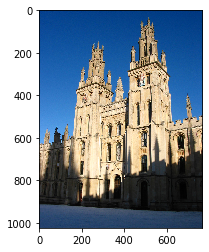

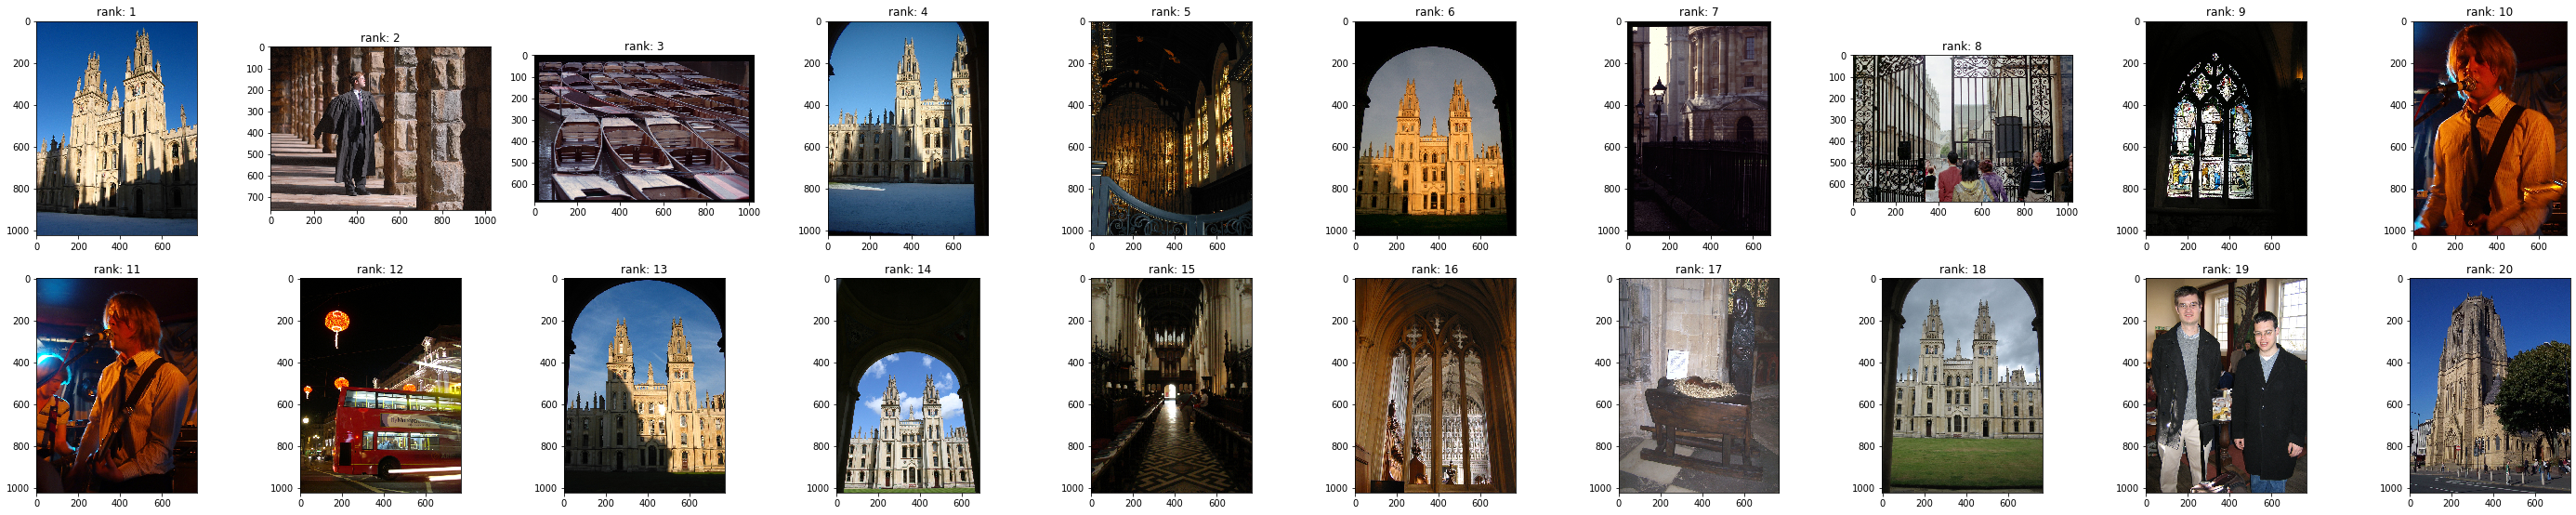

In [14]:
# construct the argument parser and parse the argument
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset",    
                type = str, 
                default='/content/drive/My Drive/oxbuild_images', 
                help = "Path to the directory of indexed images")
ap.add_argument("-f", "--features_db",  
                type = str,
                default = '/content/drive/My Drive/output/feature.hdf5'
                , help = "Path to the bag-of-visual-words database")
ap.add_argument("-b", "--bovw_db",  
                type = str,
                default = '/content/drive/My Drive/output/bovw.hdf5'
                , help = "Path to the bag-of-visual-words database")
ap.add_argument("-c", "--codebook", 
                type = str,
                default = '/content/drive/My Drive/output/vocab.cpickle', 
                help = "Path to the codebook")
ap.add_argument("-q", "--query",
                type = str,
                default = '/content/drive/My Drive/oxbuild_images/all_souls_000013.jpg',
                help = "Path to the query image")
args = vars(ap.parse_args())

# initialize the keypoint detector, local invariant descriptor, descriptor pipeline,
# distance metric, and inverted document frequency array
detector = FeatureDetector_create("SURF")
descriptor = DescriptorExtractor_create("RootSIFT")
dad = DetectAndDescribe(detector, descriptor)
distanceMetric = chi2_distance
idf = None

# if the path to the inverted document frequency is array was supplied, then load
# idf array and update the distance metric

# load the codebook vocabulary and initialize the BOVW transformer
vocab = pickle.loads(open(args["codebook"], "rb").read())
bovw = BagOfVisualWords(vocab)

# load the query image and process it
queryImage = cv2.imread(args["query"])

queryImage2 = cv2.cvtColor(queryImage, cv2.COLOR_BGR2RGB)
queryImage = imutils.resize(queryImage, width = 320)
plt.imshow(queryImage2)

queryImage = cv2.cvtColor(queryImage, cv2.COLOR_BGR2GRAY)

# extract features from the query image and construct a bag-of-visual-word from  it
(_, descs) = dad.describe(queryImage)
hist = bovw.describe(descs).tocoo()

# connect to redis and perform the search
redisDB = Redis(host = u"localhost", port = 6379, db = 0)
searcher = Searcher(redisDB, args["bovw_db"], '/content/drive/My Drive/output/feature.hdf5', idf=idf, distanceMetric = distanceMetric)

sr = searcher.search(hist, numResults = 20)
print("[INFO] search took: {:.2f}s".format(sr.search_time))

fig=plt.figure(figsize=(50, 50))
# loop over the individual results
for (i, (score, resultID, resultsIdx)) in enumerate(sr.results):
    # load the result image and display it
    print("[RESULT] {result_num}. {result} - {score:.2f}".format(result_num = i + 1,
        result = resultID, score = score))
    
    result = cv2.imread("{}/{}".format(args["dataset"], resultID))
    result = cv2.cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    fig.add_subplot(10, 10, i+1, title='rank: '+str(i+1))
    plt.imshow(result)
  
plt.show()
searcher.finish()